In [1]:
from teamwork import TeamworkPipeline, TeamworkConfig
from PIL import Image
from IPython import display
import torch
import numpy as np

In [2]:
from diffusers import FluxTransformer2DModel, GGUFQuantizationConfig
from teamwork.pipeline_flux import FluxPipeline, FluxTeamworkPipeline
from teamwork.batch import image_np2pil

In [3]:
pipe = TeamworkPipeline.from_checkpoint(
    'samsartor/teamwork-release',
    'colocated_svbrdf_estimation_sdxl_256.safetensors',
)
pipe.empty_prompts(device='cuda')
pipe = pipe.to('cuda')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
def halfway_vectors(w, h, camera_pos, light_pos):
    surface = np.indices((h, w)) + 0.5
    surface = np.stack((
        2 * surface[1, :, :] / h - 1,
        -2 * surface[0, :, :] / w + 1,
        np.zeros((h, w), np.float32),
    ), axis=-1)

    wi = light_pos - surface
    wi /= np.linalg.norm(wi, axis=2, keepdims=True)

    wo = camera_pos - surface
    wo /= np.linalg.norm(wo, axis=2, keepdims=True)

    hw = wi + wo
    hw /= np.linalg.norm(hw, axis=2, keepdims=True)

    return hw

In [5]:
fov = 30
distance = 1/np.tan(np.deg2rad([fov])/2)
hw = halfway_vectors(256, 256, [0, 0, distance.item()], [0, 0, distance.item()])

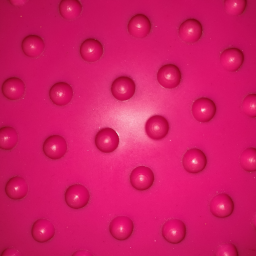

In [6]:
pink = Image.open('../demo/pink_input.png').resize([256, 256])
pink

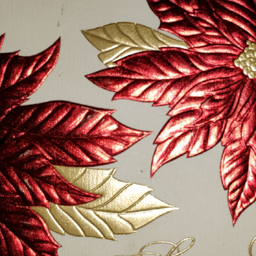

In [7]:
card = Image.open('../demo/gift_card.png').resize([256, 256])
card

In [8]:
generated = pipe([
    {'image': pink, 'halfway': hw},
    {'image': card, 'halfway': hw},
], output_type='np')

  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
from gfxds import rasterize

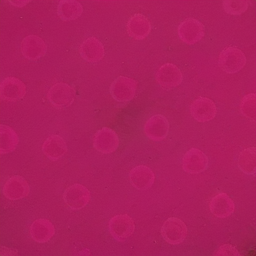

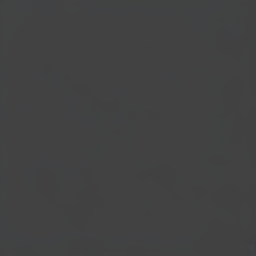

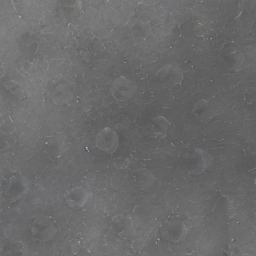

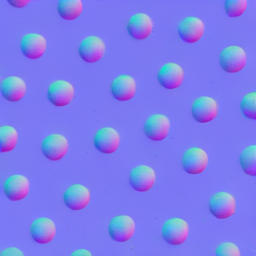

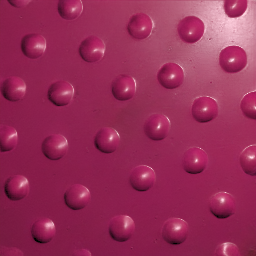

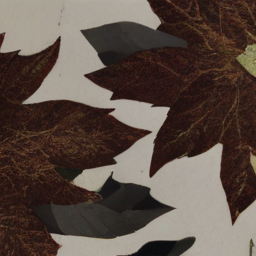

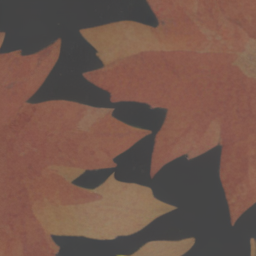

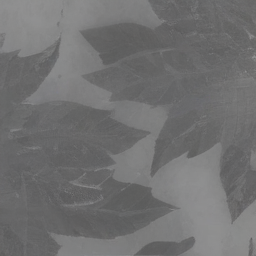

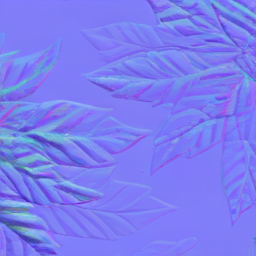

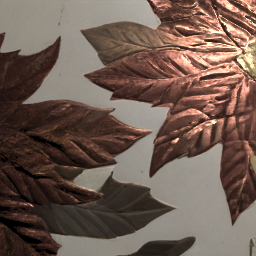

In [10]:
for generated_dict in generated:
    for name, out in generated_dict.items():
        display.display(display.HTML(f'<h2>{name}</h2>'))
        display.display(image_np2pil(out))
    display.display(display.HTML(f'<h2>Rasterized</h2>'))
    display.display(image_np2pil(rasterize(
        np.concatenate([
            generated_dict['diffuse'],
            generated_dict['specular'],
            generated_dict['roughness'][..., :1],
            generated_dict['normals'],
        ], 2),
        highlight_center=[0.75, 0.75],
        light_distance=2.41,
        camera_pos=[0.0, 0.0, 2.41],
    )[..., :3]))